## MNIST Classification / Generation using AUNN

## Setup & Definition

In [1]:
import torch
import random
import time
import torch.optim as optim
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#deallocate all cuda memory
torch.cuda.empty_cache()

#print cuda memory
print(torch.cuda.memory_allocated())

cuda
0


In [2]:
class AUNNModel(nn.Module):
    def __init__(
        self, 
        embedding_dim:int,
        output_dim:int, 
        num_layers:int, 
        hidden_dim:int):        

        assert num_layers >= 2, "Number of layers must be at least 2"

        super(AUNNModel, self).__init__() 
    
        self.embedding_dim = embedding_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Input Layer
        self.input_layer =  nn.Linear(self.embedding_dim, self.hidden_dim)

        # Hidden Layers
        self.layers = nn.ModuleList()
        for _ in range(self.num_layers - 2):  # Exclude input and output layers
            self.layers.append(nn.Sequential(
                nn.Linear(self.hidden_dim, self.hidden_dim),
                nn.SiLU(),
                nn.RMSNorm(self.hidden_dim)
            ))

        # Output Layer
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Kaiming He initialization for Swish activation
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    # binary
    def encode(self, x: torch.Tensor):
        dim = self.embedding_dim
        encoding = ((x.unsqueeze(1) >> torch.arange(dim, device=x.device)) & 1).to(torch.float32)
        return encoding

    def forward(self, indices):
        
        x = self.encode(indices)
        x = self.input_layer(x)
        x = x + nn.SiLU()(x)

        for layer in self.layers:
            x = x + layer(x)  # MLP output with skip connection

        x = self.output_layer(x)
        return x

In [3]:
# Define a function to save the model checkpoint
def save_checkpoint(model, params, optimizer, losses, filename="checkpoint.pth"):
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'params':{}
    }

    keys = ['embedding_dim', 'output_dim', 'num_layers', 'hidden_dim']
    assert all(k in params for k in keys)
    for k in keys:
        checkpoint['params'][k] = params[k]

    torch.save(checkpoint, filename)
    print(f"Checkpoint saved with loss {losses[-1]:.4f}")

In [4]:
def load_checkpoint(filename="checkpoint.pth"):

    checkpoint = torch.load(filename, weights_only=True)
    
    params = checkpoint['params']
    model = AUNNModel(**params)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    
    optimizer = optim.AdamW(model.parameters())
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    losses = checkpoint['losses']

    print(f"Checkpoint loaded: loss {losses[-1]:.4f}")

    return model, optimizer, losses

## Prepare MNIST

In [5]:
import struct
from array import array

def load_mnist(images_path, labels_path, shuffle:bool=False, binarize:bool=True, seed=42):

    labels = []
    with open(labels_path, 'rb') as file:
        magic, size = struct.unpack(">II", file.read(8)) 
        if magic != 2049:
            raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
        labels = array("B", file.read())

    images = []
    rows, cols = None, None
    with open(images_path, 'rb') as file:
        magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
        if magic != 2051:
            raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
        data = array("B", file.read())
        for i in range(size):
            img = np.array(data[i * rows * cols:(i + 1) * rows * cols], dtype=np.uint8)
            if binarize:
                img = np.where(img > 0, 1, 0) 
            img.resize((rows, cols))
            images.append(img)

    assert len(images) == len(labels)

    if shuffle:
        random.seed(seed)
        indices = list(range(len(images)))
        random.shuffle(indices)
        images = [images[i] for i in indices]
        labels = [labels[i] for i in indices]

    return images, labels


def make_string(images, labels):
    
    targets = []
    for img, label in zip(images, labels):

        img = img.flatten()

        #prep label data - create one-hot encoding
        num_repeats = len(img) // 2
        label = np.array([label] * num_repeats, dtype=np.uint16)

        #add to target
        targets.append(img)
        targets.append(label)

        #define lengths
        img_len = len(img)
        lbl_len = len(label)
        ex_len = img_len + lbl_len

    targets = np.concatenate(targets, axis=0)
    return (ex_len, img_len, lbl_len), targets


In [6]:
from pathlib import Path

cur_dir = Path().resolve()
input_path = cur_dir / 'mnist'
training_images_filepath = input_path / 'train-images.idx3-ubyte'
training_labels_filepath = input_path /'train-labels.idx1-ubyte'
test_images_filepath = input_path / 't10k-images.idx3-ubyte'
test_labels_filepath = input_path / 't10k-labels.idx1-ubyte'

train_images, train_labels = load_mnist(training_images_filepath, training_labels_filepath, shuffle=True, binarize=False)
lengths, train_data  = make_string(train_images, train_labels)
print(f"{len(train_data):,} training samples")

70,560,000 training samples


In [7]:
ex_len, img_len, lbl_len = lengths
print(f"Example length: {ex_len}, Image length: {img_len}, Label length: {lbl_len}")

Example length: 1176, Image length: 784, Label length: 392


In [8]:
#find the smallest power of 2 greater than or equal to ex_len
base_len = 1
while base_len < ex_len:
    base_len *= 2
print(f"Base length: {base_len}")

Base length: 2048


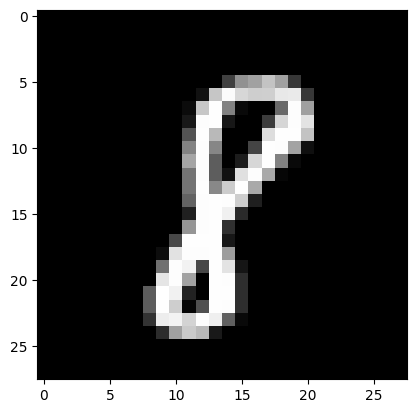

[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]


In [9]:
ex_num = 100
offset = ex_num * ex_len

# #get label bytes
# lbl_1 = train_data[offset:offset+lbl_len]
# offset += lbl_len
# print(lbl_1)

#get image bytes
img = train_data[offset:offset+img_len].reshape(28, 28)
offset += img_len
plt.imshow(img, cmap='gray')
plt.show()

#get label bytes
lbl_2 = train_data[offset:offset+lbl_len]
print(lbl_2)

## Train

In [10]:
train_data = torch.tensor(train_data, dtype=torch.long).to(device)
print(f"train_data: {train_data.shape}")

train_data: torch.Size([70560000])


In [11]:
# Hyperparameters

embedd_dim = 32
num_layers = 12    # Must be even and at least 2 (bc of skip connections)
hidden_dim = 768   # Size of hidden layers
output_dim = 2**8  # bc byte encoding

# Initialize the model

model = AUNNModel(
    embedding_dim=embedd_dim,
    output_dim=output_dim,
    num_layers=num_layers, 
    hidden_dim=hidden_dim).to(device)
print(f"Model has {model.count_params():,} parameters")

Model has 6,135,808 parameters


In [12]:
# Initialize, loss function, and optimizer

criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.AdamW(model.parameters(), lr=lr)

In [13]:
losses = []
accuracies = []

In [14]:
#pretrain on a subset of the data
num_ex = 1000
subset = train_data[:num_ex*ex_len]
print(f"subset: {subset.shape}")

subset: torch.Size([1176000])


In [15]:
# Pre-Training loop

batch_size = 4096
num_epochs = 200

num_batches = len(subset) // batch_size
if len(subset) % batch_size != 0:
    num_batches += 1

SHUFFLE_BATCHES = True
random.seed(40)

for epoch in tqdm(list(range(num_epochs))):
    batch_nums = list(range(num_batches))

    if SHUFFLE_BATCHES:
        random.shuffle(batch_nums)
    for batch_num in tqdm(batch_nums, leave=False, disable=False):

        start = batch_num * batch_size
        end = start + batch_size
        end = min(end, len(subset))
        targets = subset[start:end]

        #define absolute indices of data points
        abs_indices = torch.arange(start, end)
        #apply modulo ex_len to inputs, index relative to ex start
        data_indices = abs_indices % ex_len
        #apply floor division to inputs, index of current example
        ex_indices = abs_indices // ex_len
        #multiply ex_indices by base_len in order to align with power of 2
        assert base_len > ex_len
        ex_indices = ex_indices * base_len
        #addd data_inds to ex_inds
        indices = ex_indices + data_indices
        #move to device
        indices = indices.to(device)
        
        # Forward pass
        outputs = model(indices)
        loss = criterion(outputs, targets)
        loss.backward()

        # Perform optimization
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Clip gradients
        optimizer.step()
        optimizer.zero_grad(set_to_none=True) # Flush gradients

        if loss != loss:
            print("ERR loss is NaN")

        cur_loss = loss.item()
        losses.append(cur_loss)

        # Calculate accuracy
        preds = outputs.argmax(dim=1)
        accuracy = (preds == targets).float().mean().item()
        accuracies.append(accuracy)

        # Batch logging
        if batch_num % 1000 == 0 and batch_num != 0:
            avg_loss = np.mean(losses[-1000:])
            avg_accuracy = np.mean(accuracies[-1000:])
            print(f"Batch [{batch_num}/{num_batches}], Loss: {avg_loss:.8f}, Accuracy: {avg_accuracy:.8f}", end="\r")

    # Epoch logging
    avg_loss = np.mean(losses[-num_batches:])
    avg_accuracy = np.mean(accuracies[-num_batches:])
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.8f}, Accuracy: {avg_accuracy:.8f}")

    if avg_accuracy == 1.0:
        print("Memorization of subset achieved, stopping training.")
        break


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [1/200], Loss: 5.35833284, Accuracy: 0.47985670


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [2/200], Loss: 2.83911703, Accuracy: 0.55877177


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [3/200], Loss: 2.39007132, Accuracy: 0.56732129


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [4/200], Loss: 2.15515804, Accuracy: 0.56995828


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [5/200], Loss: 1.97523866, Accuracy: 0.56959534


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [6/200], Loss: 1.89739198, Accuracy: 0.56977675


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [7/200], Loss: 1.83512032, Accuracy: 0.57492574


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [8/200], Loss: 1.77045865, Accuracy: 0.57866160


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [9/200], Loss: 1.73581945, Accuracy: 0.57947540


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [10/200], Loss: 1.69077434, Accuracy: 0.57995315


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [11/200], Loss: 1.66107898, Accuracy: 0.58550856


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [12/200], Loss: 1.62687797, Accuracy: 0.59560310


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [13/200], Loss: 1.60489808, Accuracy: 0.59834374


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [14/200], Loss: 1.56906866, Accuracy: 0.60542588


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [15/200], Loss: 1.54378335, Accuracy: 0.60730574


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [16/200], Loss: 1.51428806, Accuracy: 0.61607785


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [17/200], Loss: 1.47595664, Accuracy: 0.62884170


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [18/200], Loss: 1.45400224, Accuracy: 0.64361064


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [19/200], Loss: 1.40265174, Accuracy: 0.65960536


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [20/200], Loss: 1.35290847, Accuracy: 0.67444150


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [21/200], Loss: 1.28847667, Accuracy: 0.69578383


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [22/200], Loss: 1.23451445, Accuracy: 0.71080695


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [23/200], Loss: 1.16372089, Accuracy: 0.74096680


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [24/200], Loss: 1.10630297, Accuracy: 0.75808897


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [25/200], Loss: 1.02158884, Accuracy: 0.78077020


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [26/200], Loss: 0.95685389, Accuracy: 0.80124325


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [27/200], Loss: 0.90199079, Accuracy: 0.81800079


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [28/200], Loss: 0.82924972, Accuracy: 0.84428914


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [29/200], Loss: 0.79463815, Accuracy: 0.85142348


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [30/200], Loss: 0.75662728, Accuracy: 0.86017778


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [31/200], Loss: 0.73354595, Accuracy: 0.86215295


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [32/200], Loss: 0.71499328, Accuracy: 0.86582608


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [33/200], Loss: 0.68914973, Accuracy: 0.86853621


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [34/200], Loss: 0.67762003, Accuracy: 0.87022654


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [35/200], Loss: 0.63846679, Accuracy: 0.87545183


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [36/200], Loss: 0.61163783, Accuracy: 0.87804667


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [37/200], Loss: 0.58130278, Accuracy: 0.88170115


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [38/200], Loss: 0.56076745, Accuracy: 0.88300239


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [39/200], Loss: 0.53953766, Accuracy: 0.88438416


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [40/200], Loss: 0.52770163, Accuracy: 0.88400099


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [41/200], Loss: 0.50726319, Accuracy: 0.88635254


  0%|          | 0/288 [00:00<?, ?it/s]

Epoch [42/200], Loss: 0.52408238, Accuracy: 0.87983449


  0%|          | 0/288 [00:00<?, ?it/s]

KeyboardInterrupt: 

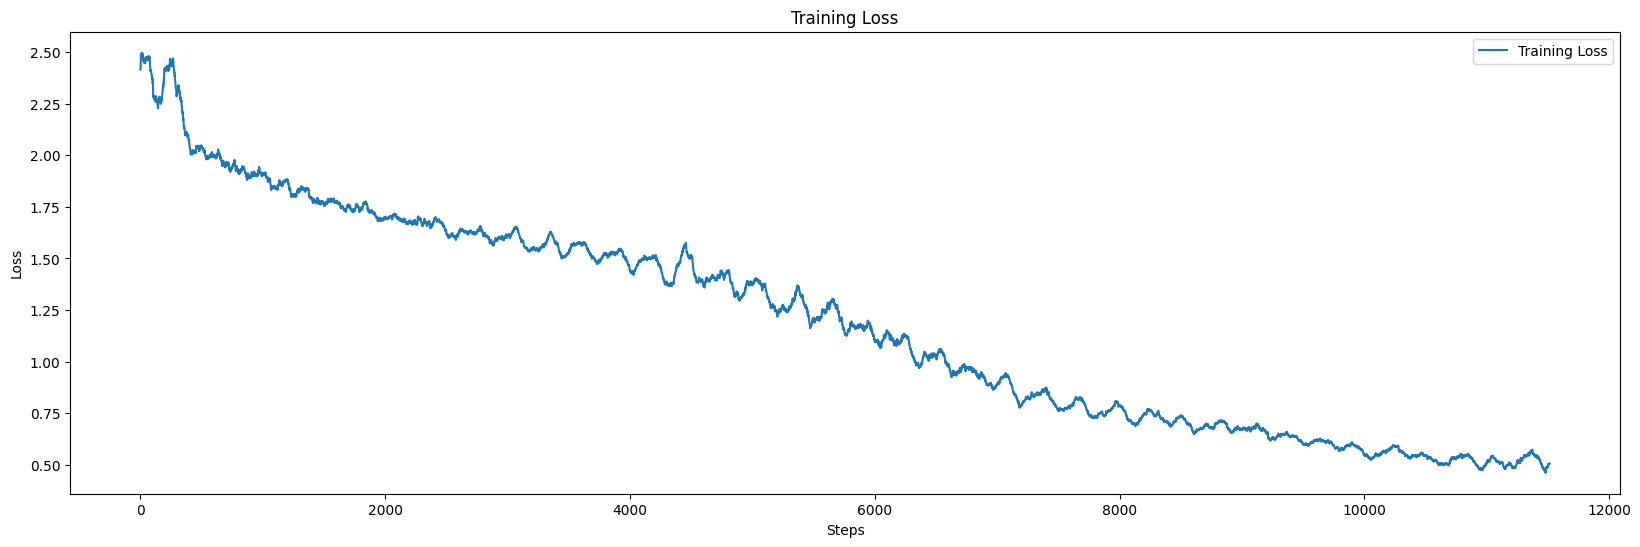

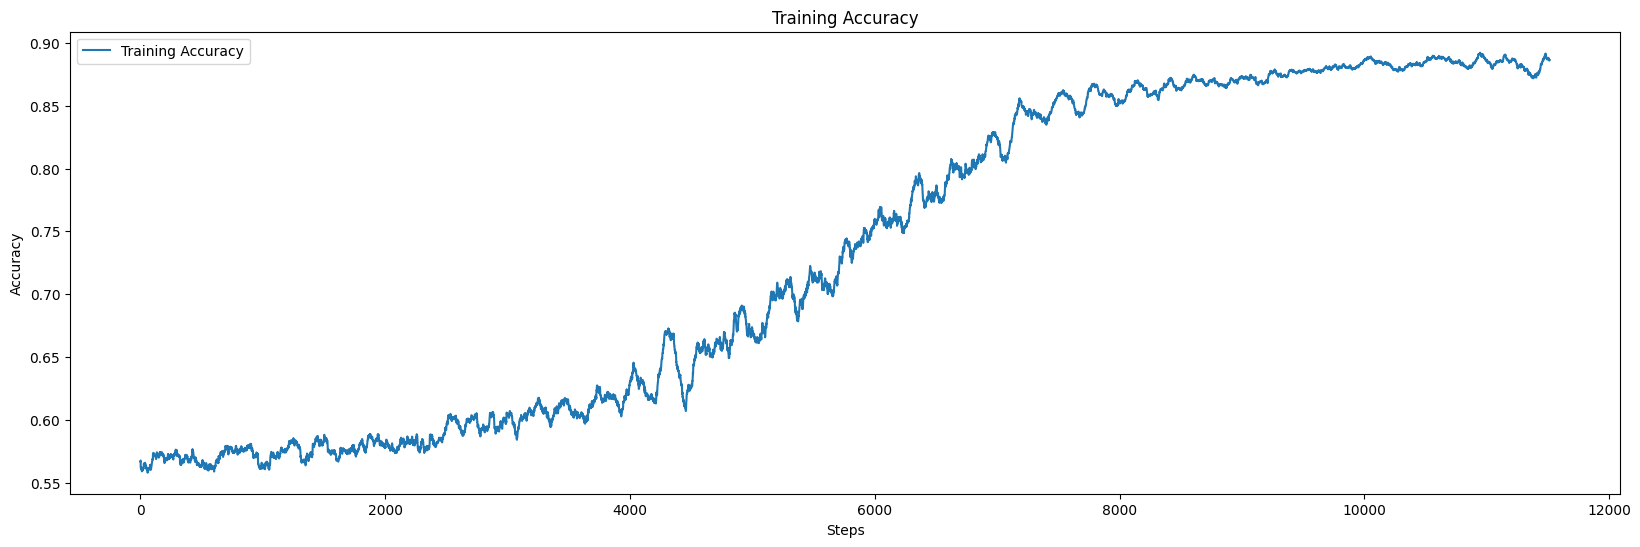

In [16]:
# Plot the loss curve
downsample = 1
window = 100

temp = []
for epoch in losses[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

# Plot the accuracy curve
temp = []
for epoch in accuracies[num_batches*2::downsample]:
    avg = np.mean(epoch)
    temp.append(avg)
temp = np.convolve(temp, np.ones(window)/window, mode='valid')

plt.figure(figsize=(20, 6))
plt.plot(temp, label="Training Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy")
plt.legend()
plt.show()

In [17]:
save_checkpoint(model, {
    'embedding_dim': embedd_dim,
    'output_dim': output_dim,
    'num_layers': num_layers,
    'hidden_dim': hidden_dim
}, optimizer, losses, filename="mnist/checkpoint_seq_1.pth")

Checkpoint saved with loss 0.3037


In [18]:
model, optimizer, losses = load_checkpoint("mnist/checkpoint_seq_1.pth")

Checkpoint loaded: loss 0.3037


so note here, that when we train in the normal way (above) but increase the subset size, that the model will fail to memorize *any* particular number information once subset size is > ~5k. The point of the next section (sequential training) is to see if the model can continue to learn generalized number-related information while retaining information about specific numbers. If you think of the weights of the AUNN as the hidden state of an RNN, then in a sense we're just reducing the amount of information required to be stored within that hidden state at a given time by doing sequential training. I had tried sequential training doing exactly 1 datapoint at a time, but that failed. It seems that sequential training requires revisiting recent points or else the AUNN "fogets" to generalize its recent learnings into a framework that also makes sense with it's recent past.

  0%|          | 0/70557648 [00:00<?, ?it/s]

UNSEEN DATA START
----- EXAMPLE 1000 START -----
IMAGE START
0 0 T 0.484664 @2048000
0 0 T 0.000100 @2048001
0 0 T 0.000100 @2048002
0 0 T 0.000100 @2048003
0 0 T 0.000100 @2048004
0 0 T 0.000100 @2048005
0 0 T 0.000100 @2048006
0 0 T 0.000100 @2048007
0 0 T 0.000100 @2048008
0 0 T 0.000100 @2048009
0 0 T 0.000100 @2048010
0 0 T 0.000100 @2048011
0 0 T 0.000100 @2048012
0 0 T 0.000100 @2048013
0 0 T 0.000100 @2048014
0 0 T 0.000100 @2048015
0 0 T 0.000100 @2048016
0 0 T 0.000100 @2048017
0 0 T 0.000100 @2048018
0 0 T 0.000100 @2048019
0 0 T 0.000100 @2048020
0 0 T 0.000100 @2048021
0 0 T 0.000100 @2048022
0 0 T 0.000100 @2048023
0 0 T 0.000100 @2048024
0 0 T 0.000100 @2048025
0 0 T 0.000100 @2048026
0 0 T 0.000100 @2048027
0 0 T 0.000100 @2048028
0 0 T 0.000100 @2048029
0 0 T 0.000100 @2048030
0 0 T 0.000100 @2048031
0 0 T 0.000100 @2048032
0 0 T 0.000100 @2048033
0 0 T 0.000100 @2048034
0 0 T 0.000100 @2048035
0 0 T 0.000100 @2048036
0 0 T 0.000100 @2048037
0 0 T 0.000100 @2048038
0 0

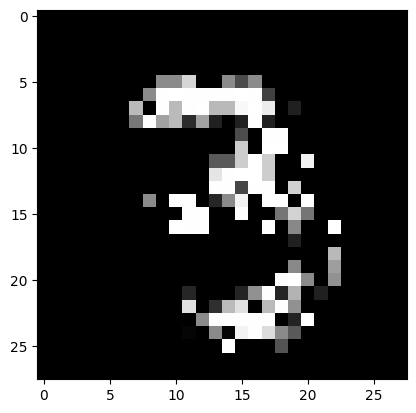

LABEL START
3 0 F 0.005382 @2048784
3 3 T 0.000094 @2048785
3 3 T 0.000158 @2048786
3 7 F 0.000864 @2048787
3 3 T 0.000087 @2048788
3 7 F 0.000753 @2048789
3 3 T 0.000074 @2048790
3 3 T 0.000075 @2048791
3 0 F 0.002199 @2048792
3 3 T 0.000059 @2048793
3 3 T 0.000104 @2048794
3 3 T 0.000053 @2048795
3 3 T 0.000129 @2048796
3 3 T 0.000235 @2048797
3 3 T 0.000077 @2048798
3 3 T 0.000077 @2048799
3 3 T 0.000077 @2048800
3 0 F 0.003039 @2048801
3 3 T 0.000069 @2048802
3 3 T 0.000076 @2048803
3 3 T 0.000076 @2048804
3 3 T 0.000138 @2048805
3 3 T 0.000091 @2048806
3 3 T 0.000371 @2048807
3 3 T 0.000049 @2048808
3 3 T 0.000050 @2048809
3 3 T 0.000050 @2048810
3 3 T 0.000051 @2048811
3 3 T 0.000051 @2048812
3 3 T 0.000057 @2048813
3 3 T 0.000083 @2048814
3 3 T 0.000100 @2048815
3 3 T 0.000061 @2048816
3 3 T 0.000061 @2048817
3 3 T 0.000061 @2048818
3 3 T 0.000061 @2048819
3 3 T 0.000061 @2048820
3 3 T 0.000061 @2048821
3 3 T 0.000062 @2048822
3 3 T 0.000062 @2048823
3 3 T 0.000062 @2048824
3 3 

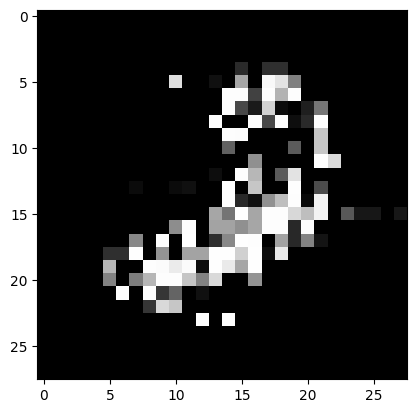

LABEL START
2 3 F 0.006295 @2050832
2 2 T 0.000075 @2050833
2 2 T 0.000305 @2050834
2 2 T 0.000193 @2050835
2 2 T 0.000051 @2050836
2 2 T 0.000065 @2050837
2 2 T 0.000187 @2050838
2 2 T 0.000093 @2050839
2 2 T 0.000093 @2050840
2 2 T 0.000093 @2050841
2 2 T 0.000097 @2050842
2 2 T 0.000244 @2050843
2 2 T 0.000054 @2050844
2 2 T 0.000066 @2050845
2 3 F 0.000763 @2050846
2 2 T 0.000136 @2050847
2 2 T 0.000077 @2050848
2 2 T 0.000086 @2050849
2 2 T 0.000118 @2050850
2 2 T 0.000206 @2050851
2 2 T 0.000192 @2050852
2 2 T 0.000044 @2050853
2 2 T 0.000044 @2050854
2 2 T 0.000044 @2050855
2 2 T 0.000044 @2050856
2 2 T 0.000044 @2050857
2 1 F 0.000525 @2050858
2 2 T 0.000046 @2050859
2 2 T 0.000048 @2050860
2 2 T 0.000048 @2050861
2 2 T 0.000150 @2050862
2 2 T 0.000052 @2050863
2 2 T 0.000052 @2050864
2 2 T 0.000052 @2050865
2 2 T 0.000052 @2050866
2 2 T 0.000052 @2050867
2 2 T 0.000052 @2050868
2 2 T 0.000052 @2050869
2 2 T 0.000052 @2050870
2 2 T 0.000052 @2050871
2 2 T 0.000052 @2050872
2 2 

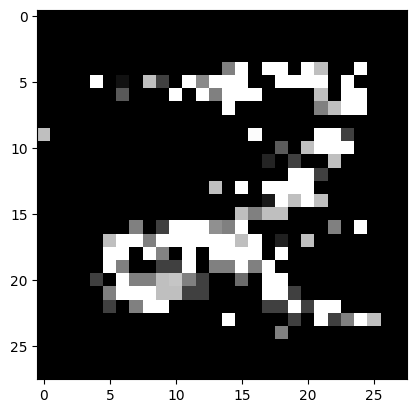

LABEL START
2 2 T 0.000096 @2052880
2 2 T 0.000097 @2052881
2 2 T 0.000097 @2052882
2 2 T 0.000098 @2052883
2 2 T 0.000098 @2052884
2 2 T 0.000115 @2052885
2 2 T 0.000075 @2052886
2 2 T 0.000078 @2052887
2 255 F 0.001587 @2052888
2 2 T 0.000063 @2052889
2 2 T 0.000063 @2052890
2 2 T 0.000063 @2052891
2 2 T 0.000063 @2052892
2 2 T 0.000063 @2052893
2 0 F 0.000371 @2052894
2 2 T 0.000081 @2052895
2 2 T 0.000081 @2052896
2 2 T 0.000129 @2052897
2 2 T 0.000067 @2052898
2 2 T 0.000067 @2052899
2 2 T 0.000067 @2052900
2 0 F 0.000604 @2052901
2 2 T 0.000087 @2052902
2 2 T 0.000087 @2052903
2 2 T 0.000087 @2052904
2 2 T 0.000087 @2052905
2 2 T 0.000087 @2052906
2 2 T 0.000087 @2052907
2 2 T 0.000087 @2052908
2 2 T 0.000087 @2052909
2 2 T 0.000087 @2052910
2 2 T 0.000087 @2052911
2 2 T 0.000087 @2052912
2 2 T 0.000087 @2052913
2 2 T 0.000087 @2052914
2 2 T 0.000087 @2052915
2 2 T 0.000087 @2052916
2 2 T 0.000087 @2052917
2 2 T 0.000088 @2052918
2 2 T 0.000088 @2052919
2 2 T 0.000088 @2052920
2 

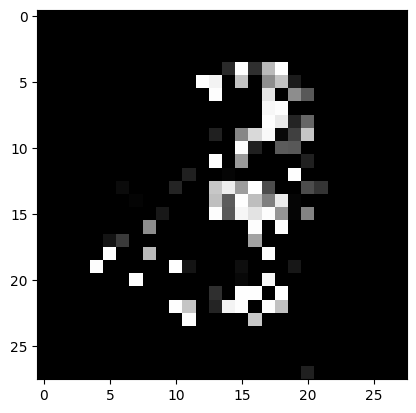

LABEL START
3 2 F 0.007077 @2054928
3 3 T 0.000148 @2054929
3 3 T 0.000066 @2054930
3 0 F 0.001424 @2054931
3 3 T 0.000071 @2054932
3 3 T 0.000405 @2054933
3 2 F 0.000670 @2054934
3 3 T 0.000098 @2054935
3 3 T 0.000110 @2054936
3 3 T 0.000089 @2054937
3 3 T 0.000156 @2054938
3 3 T 0.000104 @2054939
3 3 T 0.000205 @2054940
3 3 T 0.000082 @2054941
3 3 T 0.000085 @2054942
3 3 T 0.000088 @2054943
3 0 F 0.003073 @2054944
3 3 T 0.000083 @2054945
3 3 T 0.000242 @2054946
3 2 F 0.000983 @2054947
3 3 T 0.000098 @2054948
3 3 T 0.000140 @2054949
3 3 T 0.000131 @2054950
3 3 T 0.000095 @2054951
3 3 T 0.000096 @2054952
3 0 F 0.000584 @2054953
3 3 T 0.000085 @2054954
3 3 T 0.000097 @2054955
3 3 T 0.000102 @2054956
3 3 T 0.000079 @2054957
3 3 T 0.000081 @2054958
3 3 T 0.000086 @2054959
3 3 T 0.000086 @2054960
3 3 T 0.000085 @2054961
3 3 T 0.000085 @2054962
3 3 T 0.000085 @2054963
3 3 T 0.000085 @2054964
3 3 T 0.000085 @2054965
3 3 T 0.000085 @2054966
3 3 T 0.000085 @2054967
3 3 T 0.000085 @2054968
3 3 

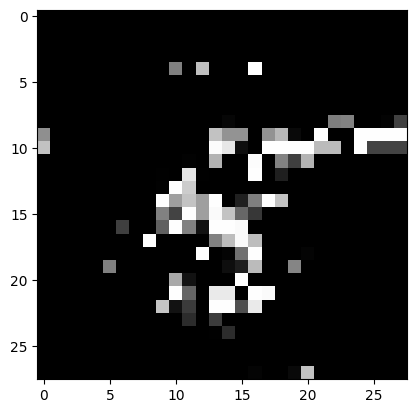

LABEL START
5 254 F 0.003494 @2056976
5 5 T 0.000051 @2056977
5 5 T 0.000052 @2056978
5 5 T 0.000123 @2056979
5 5 T 0.000086 @2056980
5 5 T 0.000092 @2056981
5 5 T 0.000141 @2056982
5 5 T 0.000311 @2056983
5 5 T 0.000103 @2056984
5 5 T 0.000095 @2056985
5 0 F 0.000455 @2056986
5 5 T 0.000138 @2056987
5 5 T 0.000360 @2056988
5 5 T 0.000097 @2056989
5 5 T 0.000098 @2056990
5 5 T 0.000099 @2056991
5 5 T 0.000271 @2056992
5 3 F 0.001020 @2056993
5 5 T 0.000097 @2056994
5 5 T 0.000367 @2056995
5 5 T 0.000085 @2056996
5 2 F 0.000419 @2056997
5 5 T 0.000072 @2056998
5 5 T 0.000072 @2056999
5 5 T 0.000072 @2057000
5 5 T 0.000083 @2057001
5 5 T 0.000083 @2057002
5 5 T 0.000148 @2057003
5 5 T 0.000269 @2057004
5 5 T 0.000155 @2057005
5 5 T 0.000094 @2057006
5 5 T 0.000098 @2057007
5 5 T 0.000097 @2057008
5 5 T 0.000083 @2057009
5 5 T 0.000082 @2057010
5 5 T 0.000082 @2057011
5 5 T 0.000082 @2057012
5 5 T 0.000077 @2057013
5 5 T 0.000077 @2057014
5 5 T 0.000076 @2057015
5 5 T 0.000076 @2057016
5 

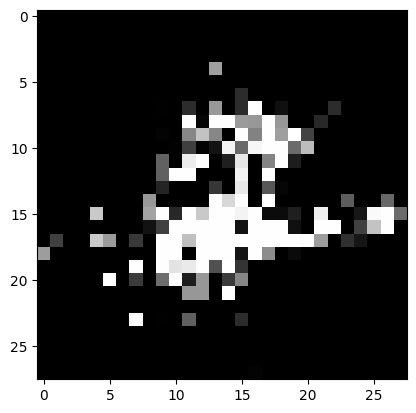

LABEL START
2 0 F 0.008362 @2059024
2 2 T 0.000054 @2059025
2 2 T 0.000054 @2059026
2 2 T 0.000070 @2059027
2 2 T 0.000134 @2059028
2 5 F 0.000610 @2059029
2 2 T 0.000364 @2059030
2 2 T 0.000102 @2059031
2 2 T 0.000067 @2059032
2 2 T 0.000176 @2059033
2 2 T 0.000121 @2059034
2 2 T 0.000217 @2059035
2 2 T 0.000209 @2059036
2 2 T 0.000228 @2059037
2 2 T 0.000126 @2059038
2 0 F 0.001812 @2059039
2 5 F 0.000466 @2059040
2 2 T 0.000355 @2059041
2 2 T 0.000091 @2059042
2 2 T 0.000157 @2059043
2 2 T 0.000097 @2059044
2 2 T 0.000097 @2059045
2 2 T 0.000097 @2059046
2 2 T 0.000098 @2059047
2 2 T 0.000146 @2059048
2 2 T 0.000156 @2059049
2 3 F 0.000577 @2059050
2 2 T 0.000126 @2059051
2 2 T 0.000078 @2059052
2 2 T 0.000078 @2059053
2 2 T 0.000082 @2059054
2 2 T 0.000087 @2059055
2 2 T 0.000087 @2059056
2 2 T 0.000087 @2059057
2 2 T 0.000087 @2059058
2 2 T 0.000086 @2059059
2 2 T 0.000086 @2059060
2 2 T 0.000086 @2059061
2 2 T 0.000086 @2059062
2 2 T 0.000085 @2059063
2 2 T 0.000085 @2059064
2 2 

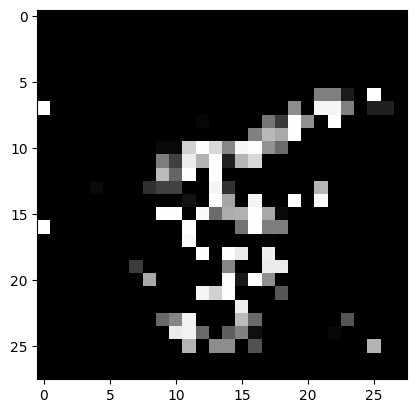

LABEL START
5 2 F 0.001706 @2061072
5 5 T 0.000069 @2061073
5 5 T 0.000082 @2061074
5 5 T 0.000082 @2061075
5 5 T 0.000084 @2061076
5 5 T 0.000084 @2061077
5 5 T 0.000084 @2061078
5 5 T 0.000084 @2061079
5 5 T 0.000383 @2061080
5 5 T 0.000052 @2061081
5 5 T 0.000052 @2061082
5 5 T 0.000052 @2061083
5 5 T 0.000052 @2061084
5 5 T 0.000052 @2061085
5 5 T 0.000052 @2061086
5 5 T 0.000052 @2061087
5 9 F 0.003147 @2061088
5 5 T 0.000096 @2061089
5 5 T 0.000096 @2061090
5 5 T 0.000096 @2061091
5 5 T 0.000096 @2061092
5 5 T 0.000096 @2061093
5 5 T 0.000096 @2061094
5 5 T 0.000096 @2061095
5 5 T 0.000096 @2061096
5 5 T 0.000096 @2061097
5 5 T 0.000096 @2061098
5 5 T 0.000096 @2061099
5 5 T 0.000096 @2061100
5 5 T 0.000096 @2061101
5 5 T 0.000096 @2061102
5 5 T 0.000096 @2061103
5 5 T 0.000096 @2061104
5 5 T 0.000096 @2061105
5 5 T 0.000096 @2061106
5 5 T 0.000096 @2061107
5 5 T 0.000096 @2061108
5 5 T 0.000096 @2061109
5 5 T 0.000096 @2061110
5 5 T 0.000096 @2061111
5 5 T 0.000096 @2061112
5 5 

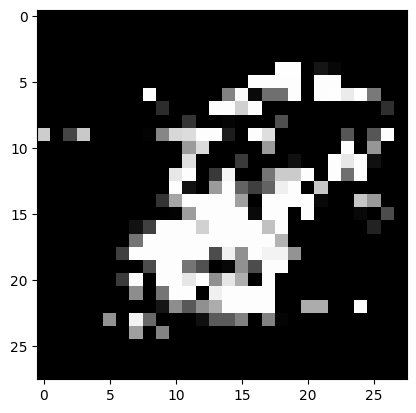

LABEL START
8 2 F 0.009323 @2063120
8 8 T 0.000088 @2063121
8 8 T 0.000088 @2063122
8 8 T 0.000089 @2063123
8 8 T 0.000090 @2063124
8 8 T 0.000097 @2063125
8 0 F 0.000942 @2063126
8 5 F 0.000645 @2063127
8 8 T 0.000095 @2063128
8 8 T 0.000095 @2063129
8 8 T 0.000095 @2063130
8 0 F 0.000919 @2063131
8 8 T 0.000060 @2063132
8 8 T 0.000060 @2063133
8 8 T 0.000060 @2063134
8 8 T 0.000060 @2063135
8 8 T 0.000076 @2063136
8 8 T 0.000216 @2063137
8 2 F 0.001501 @2063138
8 8 T 0.000105 @2063139
8 8 T 0.000176 @2063140
8 8 T 0.000216 @2063141
8 8 T 0.000090 @2063142
8 8 T 0.000107 @2063143
8 8 T 0.000074 @2063144
8 8 T 0.000074 @2063145
8 8 T 0.000074 @2063146
8 8 T 0.000074 @2063147
8 8 T 0.000074 @2063148
8 8 T 0.000074 @2063149
8 8 T 0.000074 @2063150
8 8 T 0.000074 @2063151
8 8 T 0.000074 @2063152
8 8 T 0.000074 @2063153
8 8 T 0.000074 @2063154
8 8 T 0.000074 @2063155
8 8 T 0.000074 @2063156
8 8 T 0.000074 @2063157
8 8 T 0.000074 @2063158
8 8 T 0.000074 @2063159
8 8 T 0.000074 @2063160
8 8 

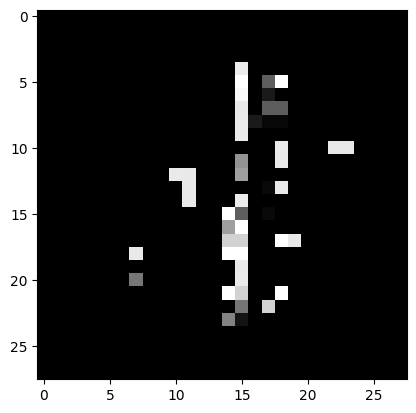

LABEL START
1 0 F 0.010928 @2065168
1 1 T 0.000076 @2065169
1 1 T 0.000076 @2065170
1 1 T 0.000077 @2065171
1 1 T 0.000077 @2065172
1 1 T 0.000079 @2065173
1 1 T 0.000082 @2065174
1 1 T 0.000205 @2065175
1 1 T 0.000094 @2065176
1 1 T 0.000094 @2065177
1 1 T 0.000094 @2065178
1 1 T 0.000135 @2065179
1 0 F 0.000751 @2065180
1 0 F 0.002882 @2065181
1 1 T 0.000039 @2065182
1 1 T 0.000098 @2065183
1 5 F 0.000528 @2065184
1 5 F 0.000613 @2065185
1 0 F 0.001071 @2065186
1 1 T 0.000040 @2065187
1 1 T 0.000040 @2065188
1 1 T 0.000042 @2065189
1 1 T 0.000057 @2065190
1 8 F 0.000533 @2065191
1 1 T 0.000029 @2065192
1 1 T 0.000029 @2065193
1 1 T 0.000031 @2065194
1 1 T 0.000035 @2065195
1 1 T 0.000035 @2065196
1 1 T 0.000039 @2065197
1 1 T 0.000091 @2065198
1 0 F 0.000690 @2065199
1 1 T 0.000060 @2065200
1 1 T 0.000060 @2065201
1 1 T 0.000060 @2065202
1 1 T 0.000060 @2065203
1 1 T 0.000060 @2065204
1 1 T 0.000060 @2065205
1 1 T 0.000063 @2065206
1 1 T 0.000063 @2065207
1 1 T 0.000063 @2065208
1 1 

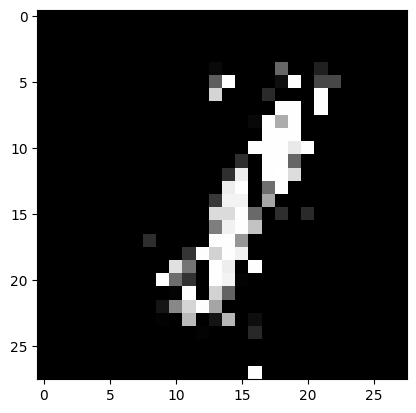

LABEL START
1 1 T 0.000146 @2067216
1 0 F 0.002660 @2067217
1 1 T 0.000078 @2067218
1 1 T 0.000079 @2067219
1 1 T 0.000079 @2067220
1 1 T 0.000080 @2067221
1 8 F 0.002660 @2067222
1 1 T 0.000070 @2067223
1 1 T 0.000070 @2067224
1 1 T 0.000070 @2067225
1 1 T 0.000070 @2067226
1 1 T 0.000070 @2067227
1 1 T 0.000070 @2067228
1 1 T 0.000070 @2067229
1 1 T 0.000079 @2067230
1 1 T 0.000084 @2067231
1 1 T 0.000085 @2067232
1 1 T 0.000085 @2067233
1 8 F 0.001029 @2067234
1 1 T 0.000062 @2067235
1 1 T 0.000062 @2067236
1 1 T 0.000062 @2067237
1 1 T 0.000062 @2067238
1 1 T 0.000062 @2067239
1 1 T 0.000062 @2067240
1 1 T 0.000062 @2067241
1 1 T 0.000063 @2067242
1 1 T 0.000071 @2067243
1 1 T 0.000071 @2067244
1 1 T 0.000071 @2067245
1 1 T 0.000072 @2067246
1 1 T 0.000074 @2067247
1 1 T 0.000074 @2067248
1 1 T 0.000074 @2067249
1 1 T 0.000074 @2067250
1 1 T 0.000074 @2067251
1 1 T 0.000074 @2067252
1 1 T 0.000074 @2067253
1 1 T 0.000074 @2067254
1 1 T 0.000074 @2067255
1 1 T 0.000074 @2067256
1 1 

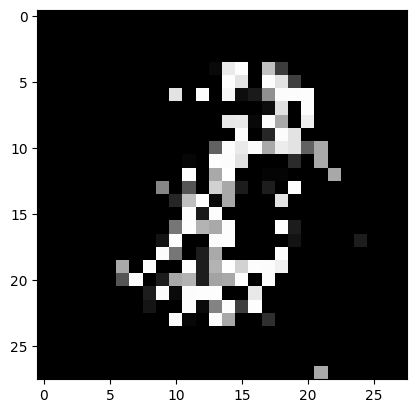

LABEL START
0 1 F 0.011928 @2069264
0 1 F 0.002493 @2069265
0 0 T 0.000086 @2069266
0 0 T 0.000086 @2069267
0 0 T 0.000086 @2069268
0 0 T 0.000086 @2069269
0 0 T 0.000086 @2069270
0 0 T 0.000086 @2069271
0 0 T 0.000131 @2069272
0 0 T 0.000100 @2069273
0 0 T 0.000082 @2069274
0 0 T 0.000085 @2069275
0 0 T 0.000241 @2069276
0 0 T 0.000065 @2069277
0 0 T 0.000065 @2069278
0 0 T 0.000065 @2069279
0 0 T 0.000065 @2069280
0 0 T 0.000066 @2069281
0 0 T 0.000066 @2069282
0 0 T 0.000066 @2069283
0 0 T 0.000120 @2069284
0 0 T 0.000083 @2069285
0 0 T 0.000091 @2069286
0 0 T 0.000180 @2069287
0 0 T 0.000082 @2069288
0 0 T 0.000082 @2069289
0 0 T 0.000102 @2069290
0 0 T 0.000107 @2069291
0 0 T 0.000065 @2069292
0 0 T 0.000076 @2069293
0 0 T 0.000078 @2069294
0 0 T 0.000083 @2069295
0 0 T 0.000083 @2069296
0 0 T 0.000083 @2069297
0 0 T 0.000083 @2069298
0 0 T 0.000083 @2069299
0 0 T 0.000083 @2069300
0 0 T 0.000083 @2069301
0 0 T 0.000198 @2069302
0 0 T 0.000097 @2069303
0 0 T 0.000097 @2069304
0 0 

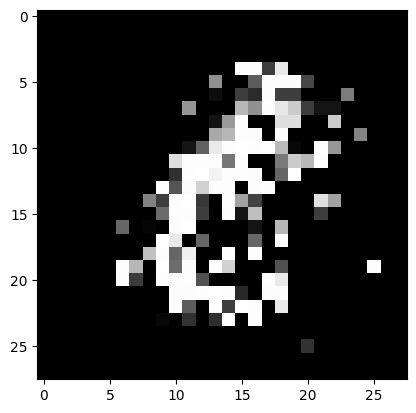

LABEL START
0 0 T 0.000068 @2071312
0 0 T 0.000070 @2071313
0 0 T 0.000198 @2071314
0 0 T 0.000094 @2071315
0 0 T 0.000094 @2071316
0 0 T 0.000094 @2071317
0 0 T 0.000094 @2071318
0 0 T 0.000094 @2071319
0 0 T 0.000142 @2071320
0 0 T 0.000087 @2071321
0 0 T 0.000184 @2071322
0 0 T 0.000068 @2071323
0 0 T 0.000069 @2071324
0 0 T 0.000069 @2071325
0 0 T 0.000069 @2071326
0 0 T 0.000069 @2071327
0 0 T 0.000069 @2071328
0 0 T 0.000069 @2071329
0 0 T 0.000069 @2071330
0 0 T 0.000069 @2071331
0 0 T 0.000069 @2071332
0 0 T 0.000069 @2071333
0 0 T 0.000185 @2071334
0 0 T 0.000060 @2071335
0 0 T 0.000060 @2071336
0 0 T 0.000060 @2071337
0 0 T 0.000060 @2071338
0 0 T 0.000060 @2071339
0 0 T 0.000060 @2071340
0 0 T 0.000060 @2071341
0 0 T 0.000060 @2071342
0 0 T 0.000060 @2071343
0 0 T 0.000060 @2071344
0 0 T 0.000060 @2071345
0 0 T 0.000060 @2071346
0 0 T 0.000060 @2071347
0 0 T 0.000060 @2071348
0 0 T 0.000060 @2071349
0 0 T 0.000060 @2071350
0 0 T 0.000060 @2071351
0 0 T 0.000060 @2071352
0 0 

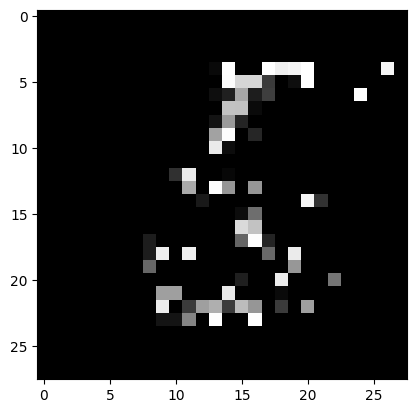

LABEL START
5 0 F 0.012588 @2073360
5 5 T 0.000074 @2073361
5 5 T 0.000075 @2073362
5 5 T 0.000306 @2073363
5 5 T 0.000098 @2073364
5 5 T 0.000139 @2073365
5 0 F 0.003282 @2073366
5 5 T 0.000035 @2073367
5 5 T 0.000035 @2073368
5 5 T 0.000035 @2073369
5 5 T 0.000035 @2073370
5 5 T 0.000040 @2073371
5 5 T 0.000145 @2073372
5 5 T 0.000064 @2073373
5 5 T 0.000092 @2073374
5 5 T 0.000355 @2073375
5 0 F 0.000998 @2073376
5 5 T 0.000095 @2073377
5 5 T 0.000096 @2073378
5 0 F 0.000928 @2073379
5 5 T 0.000044 @2073380
5 5 T 0.000044 @2073381
5 5 T 0.000091 @2073382
5 5 T 0.000091 @2073383
5 5 T 0.000102 @2073384
5 5 T 0.000049 @2073385
5 5 T 0.000051 @2073386
5 5 T 0.000052 @2073387
5 5 T 0.000067 @2073388
5 5 T 0.000067 @2073389
5 5 T 0.000090 @2073390
5 5 T 0.000092 @2073391
5 5 T 0.000092 @2073392
5 5 T 0.000092 @2073393
5 5 T 0.000092 @2073394
5 5 T 0.000092 @2073395
5 5 T 0.000092 @2073396
5 5 T 0.000092 @2073397
5 5 T 0.000092 @2073398
5 5 T 0.000091 @2073399
5 5 T 0.000091 @2073400
5 5 

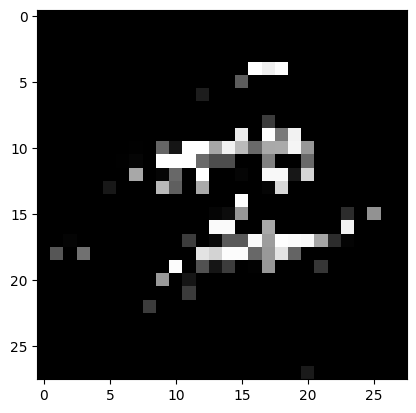

LABEL START
2 5 F 0.008422 @2075408
2 5 F 0.001678 @2075409
2 5 F 0.000762 @2075410
2 2 T 0.000101 @2075411
2 2 T 0.000096 @2075412
2 2 T 0.000214 @2075413
2 5 F 0.003009 @2075414
2 2 T 0.000082 @2075415
2 2 T 0.000082 @2075416
2 2 T 0.000082 @2075417
2 2 T 0.000082 @2075418
2 2 T 0.000082 @2075419
2 2 T 0.000086 @2075420
2 2 T 0.000100 @2075421
2 2 T 0.000053 @2075422
2 2 T 0.000082 @2075423
2 2 T 0.000089 @2075424
2 2 T 0.000091 @2075425
2 5 F 0.000391 @2075426
2 2 T 0.000358 @2075427
2 2 T 0.000082 @2075428
2 2 T 0.000082 @2075429
2 2 T 0.000087 @2075430
2 2 T 0.000089 @2075431
2 2 T 0.000205 @2075432
2 2 T 0.000163 @2075433
2 2 T 0.000045 @2075434
2 2 T 0.000045 @2075435
2 2 T 0.000045 @2075436
2 2 T 0.000045 @2075437
2 2 T 0.000066 @2075438
2 2 T 0.000080 @2075439
2 2 T 0.000080 @2075440
2 2 T 0.000080 @2075441
2 2 T 0.000080 @2075442
2 2 T 0.000080 @2075443
2 2 T 0.000080 @2075444
2 2 T 0.000080 @2075445
2 2 T 0.000080 @2075446
2 2 T 0.000080 @2075447
2 2 T 0.000080 @2075448
2 2 

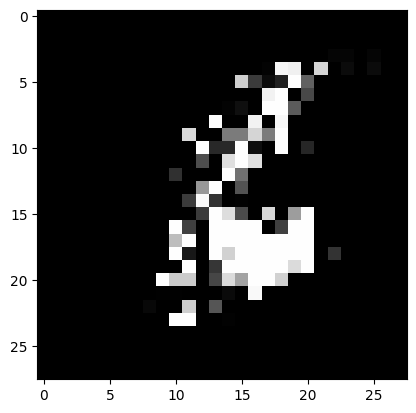

LABEL START
6 0 F 0.011896 @2077456
6 6 T 0.000093 @2077457
6 6 T 0.000093 @2077458
6 6 T 0.000094 @2077459
6 6 T 0.000107 @2077460
6 6 T 0.000350 @2077461
6 6 T 0.000096 @2077462
6 0 F 0.000933 @2077463
6 6 T 0.000069 @2077464
6 6 T 0.000070 @2077465
6 6 T 0.000070 @2077466
6 6 T 0.000072 @2077467
6 6 T 0.000074 @2077468
6 0 F 0.001509 @2077469
6 6 T 0.000096 @2077470
6 6 T 0.000105 @2077471
6 6 T 0.000102 @2077472
6 6 T 0.000049 @2077473
6 6 T 0.000091 @2077474
6 6 T 0.000110 @2077475
6 6 T 0.000058 @2077476
6 6 T 0.000059 @2077477
6 6 T 0.000108 @2077478
6 6 T 0.000071 @2077479
6 6 T 0.000118 @2077480
6 6 T 0.000118 @2077481
6 6 T 0.000068 @2077482
6 6 T 0.000087 @2077483
6 6 T 0.000337 @2077484
6 6 T 0.000096 @2077485
6 6 T 0.000106 @2077486
6 6 T 0.000058 @2077487
6 6 T 0.000058 @2077488
6 6 T 0.000058 @2077489
6 6 T 0.000058 @2077490
6 6 T 0.000058 @2077491
6 6 T 0.000058 @2077492
6 6 T 0.000056 @2077493
6 6 T 0.000055 @2077494
6 6 T 0.000055 @2077495
6 6 T 0.000055 @2077496
6 6 

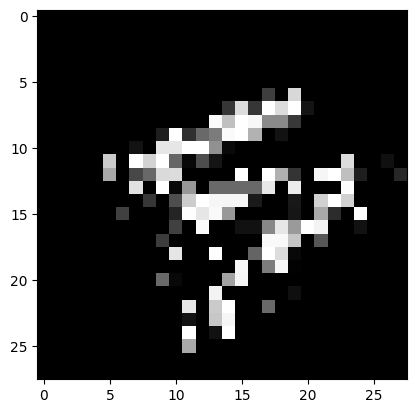

LABEL START
9 6 F 0.014093 @2079504
9 9 T 0.000095 @2079505
9 9 T 0.000095 @2079506
9 9 T 0.000401 @2079507
9 9 T 0.000066 @2079508
9 0 F 0.000963 @2079509
9 9 T 0.000194 @2079510
9 9 T 0.000108 @2079511
9 9 T 0.000045 @2079512
9 9 T 0.000045 @2079513
9 9 T 0.000045 @2079514
9 9 T 0.000048 @2079515
9 9 T 0.000049 @2079516
9 9 T 0.000126 @2079517
9 9 T 0.000111 @2079518
9 9 T 0.000106 @2079519
9 9 T 0.000077 @2079520
9 9 T 0.000078 @2079521
9 9 T 0.000130 @2079522
9 9 T 0.000043 @2079523
9 9 T 0.000043 @2079524
9 9 T 0.000043 @2079525
9 9 T 0.000065 @2079526
9 9 T 0.000110 @2079527
9 0 F 0.001234 @2079528
9 9 T 0.000091 @2079529
9 9 T 0.000092 @2079530
9 9 T 0.000189 @2079531
9 9 T 0.000069 @2079532
9 9 T 0.000071 @2079533
9 9 T 0.000182 @2079534
9 9 T 0.000062 @2079535
9 9 T 0.000062 @2079536
9 9 T 0.000062 @2079537
9 9 T 0.000062 @2079538
9 9 T 0.000062 @2079539
9 9 T 0.000062 @2079540
9 9 T 0.000062 @2079541
9 9 T 0.000062 @2079542
9 9 T 0.000062 @2079543
9 9 T 0.000062 @2079544
9 9 

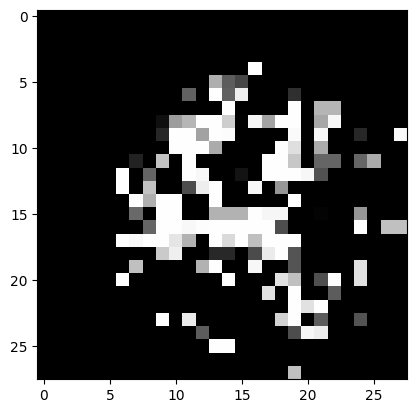

LABEL START
4 9 F 0.011037 @2081552
4 0 F 0.002328 @2081553
4 4 T 0.000082 @2081554
4 4 T 0.000081 @2081555
4 4 T 0.000081 @2081556
4 4 T 0.000081 @2081557
4 4 T 0.000081 @2081558
4 4 T 0.000188 @2081559
4 4 T 0.000076 @2081560
4 4 T 0.000076 @2081561
4 4 T 0.000076 @2081562
4 4 T 0.000077 @2081563
4 4 T 0.000077 @2081564
4 4 T 0.000193 @2081565
4 4 T 0.000398 @2081566
4 4 T 0.000089 @2081567
4 4 T 0.000089 @2081568
4 4 T 0.000195 @2081569
4 4 T 0.000057 @2081570
4 4 T 0.000057 @2081571
4 4 T 0.000059 @2081572
4 9 F 0.000474 @2081573
4 4 T 0.000041 @2081574
4 4 T 0.000128 @2081575
4 4 T 0.000040 @2081576
4 4 T 0.000041 @2081577
4 4 T 0.000041 @2081578
4 4 T 0.000041 @2081579
4 4 T 0.000042 @2081580
4 4 T 0.000043 @2081581
4 4 T 0.000056 @2081582
4 4 T 0.000092 @2081583
4 4 T 0.000092 @2081584
4 4 T 0.000084 @2081585
4 4 T 0.000083 @2081586
4 4 T 0.000083 @2081587
4 4 T 0.000083 @2081588
4 4 T 0.000083 @2081589
4 4 T 0.000083 @2081590
4 4 T 0.000083 @2081591
4 4 T 0.000083 @2081592
4 4 

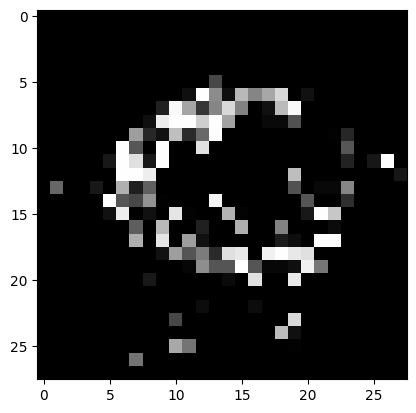

LABEL START
9 4 F 0.003530 @2083600
9 9 T 0.000175 @2083601
9 9 T 0.000061 @2083602
9 9 T 0.000062 @2083603
9 9 T 0.000064 @2083604
9 9 T 0.000066 @2083605
9 4 F 0.001041 @2083606
9 9 T 0.000099 @2083607
9 9 T 0.000099 @2083608
9 9 T 0.000099 @2083609
9 9 T 0.000099 @2083610
9 9 T 0.000099 @2083611
9 9 T 0.000099 @2083612
9 9 T 0.000099 @2083613
9 9 T 0.000099 @2083614
9 9 T 0.000099 @2083615
9 9 T 0.000099 @2083616
9 9 T 0.000099 @2083617
9 9 T 0.000099 @2083618
9 9 T 0.000099 @2083619
9 9 T 0.000099 @2083620
9 9 T 0.000099 @2083621
9 9 T 0.000099 @2083622
9 9 T 0.000099 @2083623
9 9 T 0.000099 @2083624
9 4 F 0.000451 @2083625
9 9 T 0.000085 @2083626
9 9 T 0.000085 @2083627
9 9 T 0.000086 @2083628
9 9 T 0.000111 @2083629
9 9 T 0.000070 @2083630
9 9 T 0.000070 @2083631
9 9 T 0.000070 @2083632
9 9 T 0.000070 @2083633
9 9 T 0.000070 @2083634
9 9 T 0.000070 @2083635
9 9 T 0.000070 @2083636
9 9 T 0.000070 @2083637
9 9 T 0.000070 @2083638
9 9 T 0.000070 @2083639
9 9 T 0.000070 @2083640
9 9 

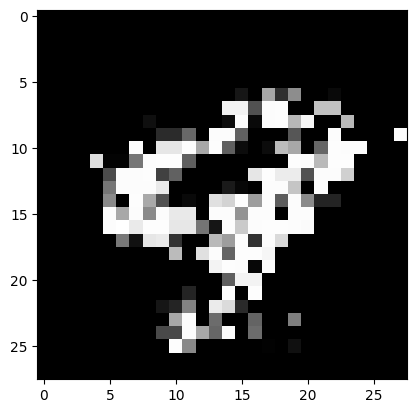

LABEL START
9 9 T 0.000091 @2085648
9 9 T 0.000091 @2085649
9 9 T 0.000092 @2085650
9 9 T 0.000092 @2085651
9 9 T 0.000140 @2085652
9 9 T 0.000091 @2085653
9 9 T 0.000091 @2085654
9 9 T 0.000091 @2085655
9 9 T 0.000095 @2085656
9 9 T 0.000095 @2085657
9 9 T 0.000095 @2085658
9 9 T 0.000096 @2085659
9 9 T 0.000096 @2085660
9 9 T 0.000098 @2085661
9 9 T 0.000098 @2085662
9 9 T 0.000098 @2085663
9 9 T 0.000099 @2085664
9 9 T 0.000116 @2085665
9 9 T 0.000098 @2085666
9 9 T 0.000123 @2085667
9 9 T 0.000084 @2085668
9 9 T 0.000221 @2085669
9 9 T 0.000091 @2085670
9 9 T 0.000176 @2085671
9 9 T 0.000093 @2085672
9 9 T 0.000093 @2085673
9 9 T 0.000095 @2085674
9 9 T 0.000095 @2085675
9 9 T 0.000095 @2085676
9 9 T 0.000095 @2085677
9 9 T 0.000095 @2085678
9 9 T 0.000095 @2085679
9 9 T 0.000095 @2085680
9 9 T 0.000095 @2085681
9 9 T 0.000095 @2085682
9 9 T 0.000095 @2085683
9 9 T 0.000096 @2085684
9 9 T 0.000096 @2085685
9 9 T 0.000096 @2085686
9 9 T 0.000096 @2085687
9 9 T 0.000096 @2085688
9 9 

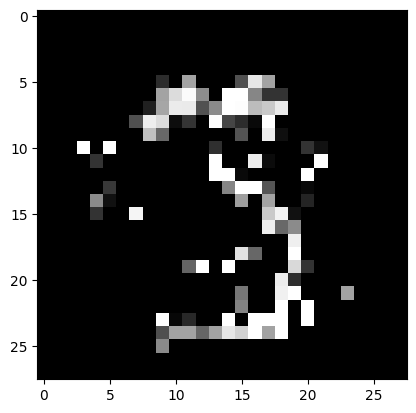

LABEL START
3 9 F 0.013797 @2087696
3 9 F 0.004040 @2087697
3 3 T 0.000069 @2087698
3 3 T 0.000068 @2087699
3 3 T 0.000069 @2087700
3 3 T 0.000191 @2087701
3 9 F 0.000481 @2087702
3 3 T 0.000190 @2087703
3 3 T 0.000096 @2087704
3 3 T 0.000130 @2087705
3 3 T 0.000096 @2087706
3 3 T 0.000151 @2087707
3 3 T 0.000118 @2087708
3 9 F 0.000799 @2087709
3 3 T 0.000095 @2087710
3 3 T 0.000360 @2087711
3 0 F 0.001094 @2087712
3 3 T 0.000045 @2087713
3 3 T 0.000165 @2087714
3 3 T 0.000115 @2087715
3 3 T 0.000085 @2087716
3 9 F 0.001596 @2087717
3 3 T 0.000030 @2087718
3 3 T 0.000143 @2087719
3 3 T 0.000038 @2087720
3 9 F 0.000962 @2087721
3 3 T 0.000087 @2087722
3 3 T 0.000088 @2087723
3 3 T 0.000260 @2087724
3 3 T 0.000053 @2087725
3 3 T 0.000052 @2087726
3 3 T 0.000051 @2087727
3 3 T 0.000050 @2087728
3 3 T 0.000050 @2087729
3 3 T 0.000050 @2087730
3 3 T 0.000050 @2087731
3 3 T 0.000050 @2087732
3 3 T 0.000050 @2087733
3 3 T 0.000050 @2087734
3 3 T 0.000050 @2087735
3 3 T 0.000050 @2087736
3 3 

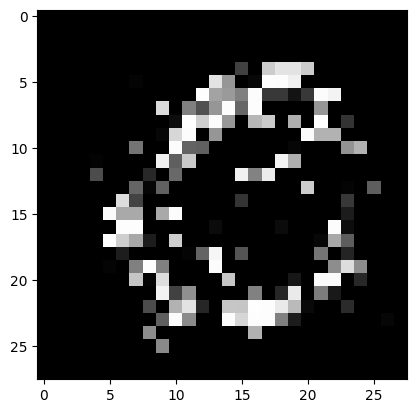

LABEL START
0 9 F 0.005729 @2089744
0 0 T 0.000101 @2089745
0 0 T 0.000067 @2089746
0 0 T 0.000150 @2089747
0 0 T 0.000060 @2089748
0 0 T 0.000313 @2089749
0 0 T 0.000479 @2089750
0 0 T 0.000165 @2089751
0 0 T 0.000047 @2089752
0 0 T 0.000048 @2089753
0 0 T 0.000048 @2089754
0 0 T 0.000049 @2089755
0 0 T 0.000051 @2089756
0 0 T 0.000052 @2089757
0 0 T 0.000120 @2089758
0 0 T 0.000044 @2089759
0 0 T 0.000045 @2089760
0 0 T 0.000045 @2089761
0 0 T 0.000092 @2089762
0 9 F 0.000719 @2089763
0 0 T 0.000038 @2089764
0 0 T 0.000039 @2089765
0 0 T 0.000042 @2089766
0 0 T 0.000049 @2089767
0 0 T 0.000050 @2089768
0 0 T 0.000050 @2089769
0 0 T 0.000054 @2089770
0 0 T 0.000178 @2089771
0 0 T 0.000043 @2089772
0 0 T 0.000050 @2089773
0 0 T 0.000122 @2089774
0 0 T 0.000088 @2089775
0 0 T 0.000091 @2089776
0 0 T 0.000091 @2089777
0 0 T 0.000091 @2089778
0 0 T 0.000091 @2089779
0 0 T 0.000153 @2089780
0 0 T 0.000086 @2089781
0 0 T 0.000086 @2089782
0 0 T 0.000086 @2089783
0 0 T 0.000088 @2089784
0 0 

KeyboardInterrupt: 

In [19]:
from tqdm.auto import tqdm

model.train()
context_len = ex_len*2
history = []

for i in tqdm(range(len(train_data) - context_len), total=len(train_data) - context_len):

    boundary = (ex_len * num_ex) - context_len
    if i == boundary:
        print("UNSEEN DATA START")
    elif i < boundary:
        continue
        
    start = i
    end = i + context_len + 1
    targets = train_data[start:end]
    abs_indices = torch.arange(start, end)
    data_indices = abs_indices % ex_len
    assert base_len >= ex_len
    ex_indices = abs_indices // ex_len
    ex_indices = ex_indices * base_len
    indices = ex_indices + data_indices
    indices = indices.to(device)
        
    j = 0
    while True:

        outputs = model(indices)
        loss = criterion(outputs, targets)
        loss_val = loss.item()

        predicted = outputs.argmax(dim=1)
        a = targets[-1].item()
        b = predicted[-1].item()

        if j == 0:
            cur_ind = indices[-1].item()
            rel_ind = cur_ind % base_len

            if rel_ind == 0:
                print(f'----- EXAMPLE {cur_ind // base_len} START -----')
                print('IMAGE START')

            elif rel_ind == img_len:
                print('IMAGE END')
                if len(history) >= img_len:
                    img = history[-img_len:]
                    img = np.array(img, dtype=np.uint16)
                    img = img.reshape(28, 28)
                    plt.imshow(img, cmap='gray')
                    plt.show()
                print('LABEL START')

            elif rel_ind == img_len + lbl_len:
                print('LABEL END')

            losses.append(loss_val)
            accuracies.append(a == b)
            history.append(b)
            print(a,b,'T' if a == b else 'F', f"{loss_val:f} @{cur_ind}" )
            
        j += 1

        loss_thresh = 0.0001
        if a == b and loss_val < loss_thresh:
            break

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


In [ ]:
save_checkpoint(model, {
    'embedding_dim': embedd_dim,
    'output_dim': output_dim,
    'num_layers': num_layers,
    'hidden_dim': hidden_dim
}, optimizer, losses, filename="mnist/checkpoint_seq_2.pth")